# Initial Attempts at SINDy
[Sparse Identification of Nonlinear Dynamics (SINDy)](https://www.pnas.org/content/113/15/3932) is an approach for learning differential equations from time-evolution data.
In short, one developes a differential equation where: $f^\prime(x) = \eta(x)$ where $\eta$ is learned from the data. 


In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LassoCV
from sklearn.pipeline import Pipeline
from scipy.integrate import solve_ivp
import pandas as pd
import numpy as np
import warnings

## Load in the Smoothed Data
We use derivatives, which are sensitive to noise in the data

In [2]:
smooth_data = pd.read_csv('datasets/smooth_data.csv').query('temp == 575')  # Get only one temperature

In [3]:
smooth_data

,void_radii,temp,frame_id,source,void_count,radius_total,radius_mean,radius_stddev,surfarea_total,surfarea_mean,...,void_count_dt,radius_total_dt,radius_mean_dt,radius_stddev_dt,surfarea_total_dt,surfarea_mean_dt,surfarea_stddev_dt,volume_total_dt,volume_mean_dt,volume_stddev_dt
1184,"[8.288790818838285, 8.377443509789549, 8.15400...",575.0,132,void_size_Ni_575C_0.7_to_3dpa_01282022.csv,155.139871,1212.521576,7.850807,1.854915,128647.860498,804.396321,...,-0.481597,-4.396977,-0.006487,0.011576,-616.287771,0.192034,3.920751,-1164.168283,2.792533,17.175099
1185,"[7.92426824088062, 6.602002906473624, 8.421419...",575.0,133,void_size_Ni_575C_0.7_to_3dpa_01282022.csv,154.660023,1208.144379,7.844373,1.866426,128036.461400,804.583798,...,-0.478096,-4.357430,-0.006383,0.011445,-606.528477,0.182957,3.860392,-1149.562026,2.752341,16.989120
1186,"[7.8304866152859285, 5.954843113816836, 8.4214...",575.0,134,void_size_Ni_575C_0.7_to_3dpa_01282022.csv,154.183684,1203.806689,7.838041,1.877806,127434.767570,804.762310,...,-0.474581,-4.317964,-0.006280,0.011315,-596.877105,0.174105,3.800793,-1135.049484,2.712898,16.804961
1187,"[7.877516987782423, 4.382645864810783, 8.76529...",575.0,135,void_size_Ni_575C_0.7_to_3dpa_01282022.csv,153.710866,1199.508424,7.831811,1.889056,126842.671477,804.932082,...,-0.471052,-4.278580,-0.006179,0.011186,-587.332873,0.165476,3.741950,-1120.630297,2.674197,16.622613
1188,"[7.8304866152859285, 4.122053492430359, 11.206...",575.0,136,void_size_Ni_575C_0.7_to_3dpa_01282022.csv,153.241584,1195.249501,7.825683,1.900179,126260.066370,805.093336,...,-0.467510,-4.239281,-0.006078,0.011059,-577.895003,0.157067,3.683857,-1106.304106,2.636232,16.442065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3988,"[5.436003166402974, 6.822129830163047, 5.57024...",575.0,2936,void_size_Ni_575C_0.7_to_3dpa_01282022.csv,191.313349,1613.703574,8.557675,4.890628,219618.486584,1180.291521,...,1.553105,10.063233,0.006022,0.003927,-467.871544,-7.680819,2.793113,-463.632468,-45.978520,-49.783785
3989,"[6.712968709769421, 4.382645864810783, 7.63947...",575.0,2937,void_size_Ni_575C_0.7_to_3dpa_01282022.csv,192.937273,1624.263023,8.563718,4.894566,219147.536100,1172.259120,...,1.695665,11.062741,0.006064,0.003949,-474.040467,-8.389118,2.830444,-464.410511,-50.249860,-54.606200
3990,"[6.4319656867244275, 6.9295715553602335, 5.367...",575.0,2938,void_size_Ni_575C_0.7_to_3dpa_01282022.csv,194.706548,1635.843383,8.569803,4.898525,218670.383485,1163.502881,...,1.843830,12.105232,0.006107,0.003970,-480.275882,-9.128628,2.868147,-465.173506,-54.706796,-59.642748
3991,"[3.9387584938912115, 4.031447845852497, 15.399...",575.0,2939,void_size_Ni_575C_0.7_to_3dpa_01282022.csv,196.626845,1648.488175,8.575931,4.902506,218186.962017,1153.991191,...,1.997729,13.191787,0.006149,0.003992,-486.578253,-9.900156,2.906225,-465.921270,-59.354059,-64.898966


Normalize it such that maximum values for each cateory are 1

In [4]:
target_cols = [c for c in smooth_data.columns[1:] if not c.endswith('_dt') and c not in ['frame_id', 'source', 'temp']]

In [5]:
scale_factors = {}
for c in target_cols:
    scale_factors[c] = smooth_data[c].max()
    smooth_data[c] /= scale_factors[c]
    smooth_data[f'{c}_dt'] /= scale_factors[c]

## Train a LASSO Model
Just to see if we get any sensible void growth predictions.
We are going to compare against JMAK, which gives us total volume, and assume that the volume growth has to do with the total surface are and - possibly - the distribution of void sizes

In [6]:
state_cols = ['volume_total', 'surfarea_total', 'radius_mean', 'radius_stddev', 'void_count']

## Step 1: Visualize the Data
Make sure it seems reasonable. Inputs are the state of the void growth

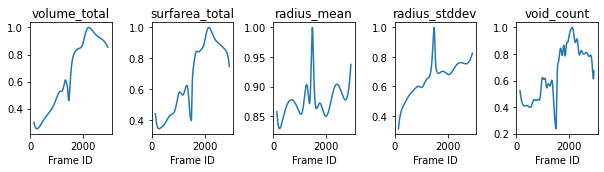

In [7]:
fig, axs = plt.subplots(1, len(state_cols), figsize=(8.5, 2.5))

input_cols = state_cols
for c, ax in zip(input_cols, axs):
    ax.plot(smooth_data['frame_id'], smooth_data[c])
    ax.set_title(c)
    ax.set_xlabel('Frame ID')
    ax.set_ylim(ax.get_ylim())
    
    
fig.tight_layout()

Outputs are the derivatives

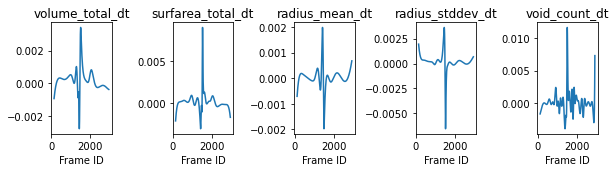

In [8]:
fig, axs = plt.subplots(1, len(state_cols), figsize=(8.5, 2.5))

output_cols = [x + '_dt' for x in state_cols]
for c, ax in zip(output_cols, axs):
    ax.plot(smooth_data['frame_id'], smooth_data[c])
    ax.set_title(c)
    ax.set_xlabel('Frame ID')
    ax.set_ylim(ax.get_ylim())
    
    
fig.tight_layout()

## Step 2: Build the Model Pipeline
We want polynomial features and then to normalize them

In [9]:
model = Pipeline([
    ('poly', PolynomialFeatures(2, include_bias=False)),
    #('scale', StandardScaler()),
    ('model', MultiOutputRegressor(LassoCV(max_iter=10000, cv=TimeSeriesSplit())))
])

## Step 3: Fit it on all the data
Just to see how it works

In [10]:
train_X = smooth_data[output_cols]

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    model.fit(smooth_data[input_cols], smooth_data[output_cols].values)

In [11]:
y_pred = model.predict(smooth_data[input_cols])

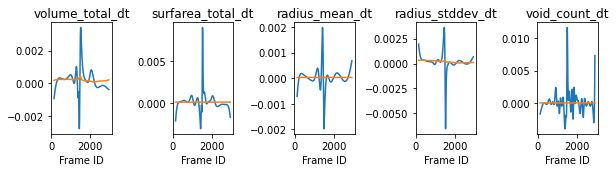

In [12]:
fig, axs = plt.subplots(1, len(output_cols), figsize=(8.5, 2.5))

for c, ax, p in zip(output_cols, axs, y_pred.T):
    ax.plot(smooth_data['frame_id'], smooth_data[c])
    ax.plot(smooth_data['frame_id'], p)
    ax.set_title(c)
    ax.set_xlabel('Frame ID')
fig.tight_layout()

Display the learned equations

In [13]:
input_names = model['poly'].get_feature_names(input_cols)
input_names

['volume_total',
 'surfarea_total',
 'radius_mean',
 'radius_stddev',
 'void_count',
 'volume_total^2',
 'volume_total surfarea_total',
 'volume_total radius_mean',
 'volume_total radius_stddev',
 'volume_total void_count',
 'surfarea_total^2',
 'surfarea_total radius_mean',
 'surfarea_total radius_stddev',
 'surfarea_total void_count',
 'radius_mean^2',
 'radius_mean radius_stddev',
 'radius_mean void_count',
 'radius_stddev^2',
 'radius_stddev void_count',
 'void_count^2']

In [14]:
for output, submodel in zip(output_cols, model['model'].estimators_):
    params = submodel.coef_
    print(f'{output} = {" + ".join(map(lambda x: f"{x[0]:.1e} * {x[1]}", zip(params[np.nonzero(params)], input_names)))} + {submodel.intercept_:.1e}')

volume_total_dt = -2.6e-04 * volume_total + 3.4e-04 * surfarea_total + 1.7e-04
surfarea_total_dt = -6.7e-20 * volume_total + 1.1e-04
radius_mean_dt =  + 2.8e-05
radius_stddev_dt = -3.8e-04 * volume_total + 4.3e-04
void_count_dt =  + 5.3e-05


## See if we can solve the PDE and achieve reasonable results
The game will be to to use up to 1500 frames and predict up to 2000

### Step 1: Fit the model
Take only the data up to the desired cycle

In [15]:
stop_frame = 1000

In [16]:
fit_data = smooth_data.query(f'frame_id < {stop_frame}')

In [17]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    model.fit(fit_data[input_cols], fit_data[output_cols])

### Step 2: Solve the IVP
Take the state at Step 1500 and propogate!

In [18]:
y0 = fit_data.iloc[-1][input_cols]
y0

volume_total      0.483138
surfarea_total    0.562426
radius_mean       0.855221
radius_stddev     0.592429
void_count        0.620625
Name: 2051, dtype: object

In [19]:
def f_prime(t, y):
    return model.predict([y])[0, :]
f_prime(1500, y0)

array([ 3.76644339e-04,  3.83135997e-04, -3.08403161e-06,  1.06708430e-04,
        6.96843924e-04])

In [20]:
res = solve_ivp(f_prime, [stop_frame, 2000], y0, t_eval=np.linspace(stop_frame, 2000, 256))

Plot the outcome

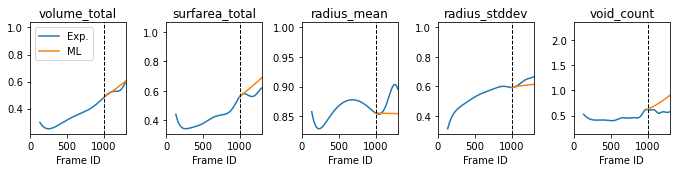

In [21]:
fig, axs = plt.subplots(1, len(output_cols), figsize=(9.5, 2.5))

axs = axs.flatten()

for c, ax, p in zip(input_cols, axs, res.y):
    ax.plot(smooth_data['frame_id'], smooth_data[c], label='Exp.')
    ax.plot(res.t, p, label='ML')
    ax.set_title(c)
    ax.set_xlabel('Frame ID')
    ax.set_xlim(0, 1300)
    ax.set_ylim(ax.get_ylim())
    
    ax.plot([stop_frame]*2, ax.get_ylim(), 'k--', lw=1)
    
axs[0].legend()
fig.tight_layout()

👆 You can see that we miss the large increase in average void size, which is probably us forming that second population